In [1]:
## TODO: running a conditional volatility model to see if it works

import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats

sys.path.append(os.getcwd() + "/../src/")

from utils import create_dataset

btc = create_dataset()
btc = btc.reset_index(drop=True)
# btc = btc.dropna()

btc['target'] = np.log(btc['Open'].shift(-1).fillna(np.nan).values/btc['Open'].values)
btc = btc.dropna()

SEED = 2052
np.random.seed(2052)

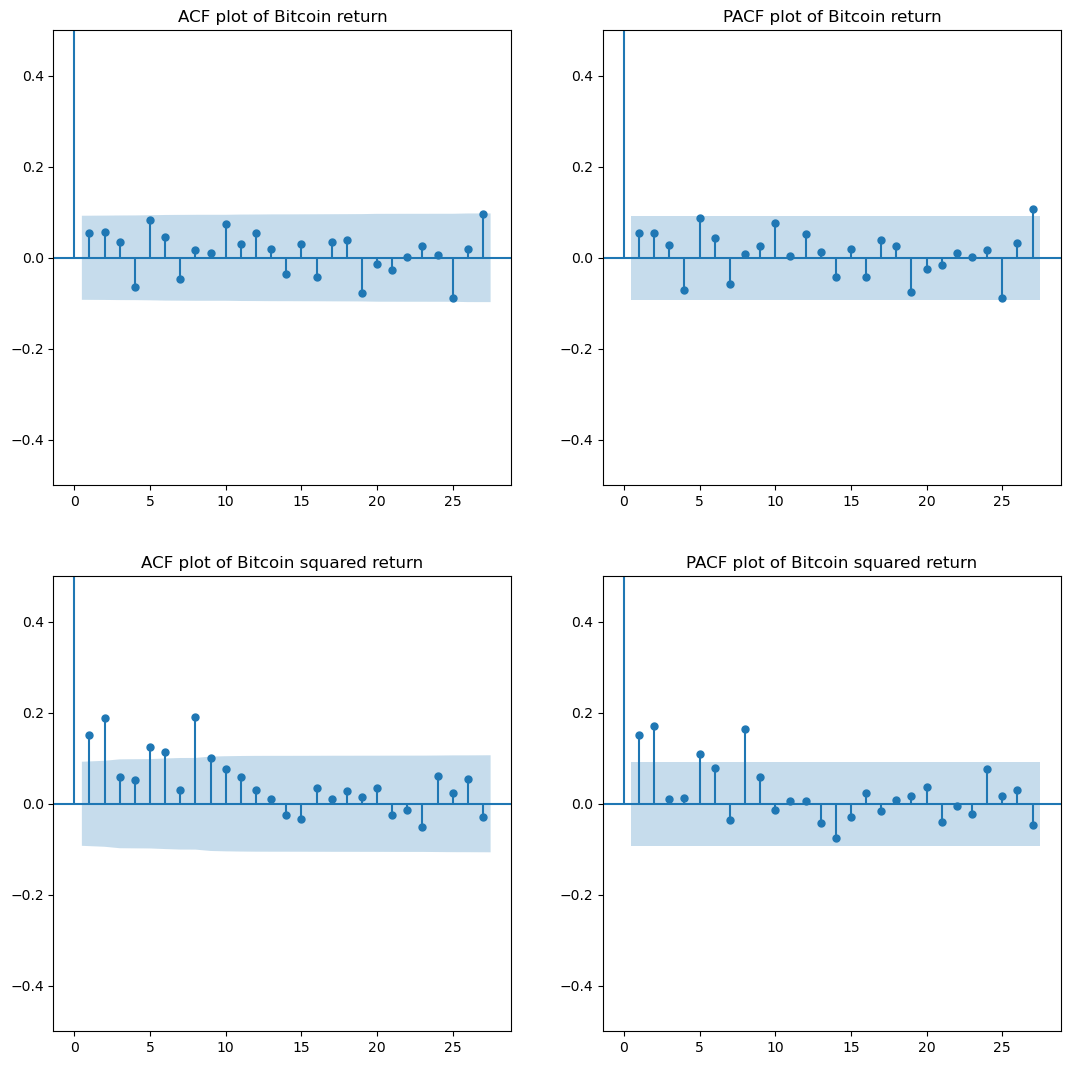

In [2]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(2, 2, figsize=(13, 13))
btc['target'] = btc['target'].astype(np.float64)

plot_acf(btc['target'].values, ax=ax[0, 0])
ax[0, 0].set(title="ACF plot of Bitcoin return")
ax[0, 0].set_ylim([-0.5, 0.5])

plot_pacf(btc['target'].values, ax=ax[0, 1])
ax[0, 1].set(title="PACF plot of Bitcoin return")
ax[0, 1].set_ylim([-0.5, 0.5])

plot_acf(btc['target'].values ** 2, ax=ax[1, 0])
ax[1, 0].set(title="ACF plot of Bitcoin squared return")
ax[1, 0].set_ylim([-0.5, 0.5])

plot_pacf(btc['target'].values ** 2, ax=ax[1, 1])
ax[1, 1].set(title="PACF plot of Bitcoin squared return")
ax[1, 1].set_ylim([-0.5, 0.5])
plt.show()

In [14]:
garch11 = arch_model(
    btc['target'].values,
    vol="GARCH",
    p=5,
    q=0,
    mean="HAR",
    dist="StudentsT",
)

garch11_fit = garch11.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 2233.270236453546
Iteration:      2,   Func. Count:     24,   Neg. LLF: -130.92322050713562
Iteration:      3,   Func. Count:     36,   Neg. LLF: 189.37782000862907
Iteration:      4,   Func. Count:     46,   Neg. LLF: 154.72582038357774
Iteration:      5,   Func. Count:     56,   Neg. LLF: 414.3696152270928
Iteration:      6,   Func. Count:     66,   Neg. LLF: 66.47434973371846
Iteration:      7,   Func. Count:     76,   Neg. LLF: 72.6433428351965
Iteration:      8,   Func. Count:     87,   Neg. LLF: -40.62850867380516
Iteration:      9,   Func. Count:     97,   Neg. LLF: -255.59101016904492
Iteration:     10,   Func. Count:    107,   Neg. LLF: -434.3539600713
Iteration:     11,   Func. Count:    117,   Neg. LLF: -443.4743584080758
Iteration:     12,   Func. Count:    126,   Neg. LLF: -443.54966928826224
Iteration:     13,   Func. Count:    135,   Neg. LLF: -443.5793563027105
Iteration:     14,   Func. Count:    144,   Neg. LLF: -4

/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [15]:
# Diagnostic tests for GARCH(1,1) Model with Normal White Noise
print("GARCH(2,0) Model with Normal White Noise\n")

# Ljung-Box test and the Box-Pierce test
print("Ljung-Box and Box-Pierce tests on stanrdized residuals")
print(acorr_ljungbox(garch11_fit.std_resid, boxpierce=True))

print("\nLjung-Box and Box-Pierce tests on stanrdized squared residuals")
print(acorr_ljungbox(garch11_fit.std_resid**2, boxpierce=True))

# ARCH LM test for conditional heteroskedasticity
print("\nARCH LM test for conditional heteroskedasticity")
print(garch11_fit.arch_lm_test(standardized=True))

GARCH(2,0) Model with Normal White Noise

Ljung-Box and Box-Pierce tests on stanrdized residuals
      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    4.608362   0.031816   4.577775   0.032389
2    6.675654   0.035514   6.626773   0.036393
3    6.969407   0.072879   6.917277   0.074582
4    7.408303   0.115821   7.350347   0.118492
5   10.050549   0.073816   9.951673   0.076616
6   10.064858   0.121947   9.965728   0.126103
7   10.593236   0.157372  10.483585   0.162785
8   11.002498   0.201558  10.883793   0.208371
9   11.323880   0.254160  11.197354   0.262424
10  13.663014   0.188925  13.474387   0.198344

Ljung-Box and Box-Pierce tests on stanrdized squared residuals
     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1   0.037322   0.846811  0.037074   0.847314
2   0.320195   0.852061  0.317444   0.853233
3   0.861095   0.834805  0.852361   0.836906
4   2.538862   0.637691  2.507856   0.643230
5   2.703448   0.745591  2.669893   0.750719
6   2.753131   0.839132  2.718697   0.843234
7   3.5

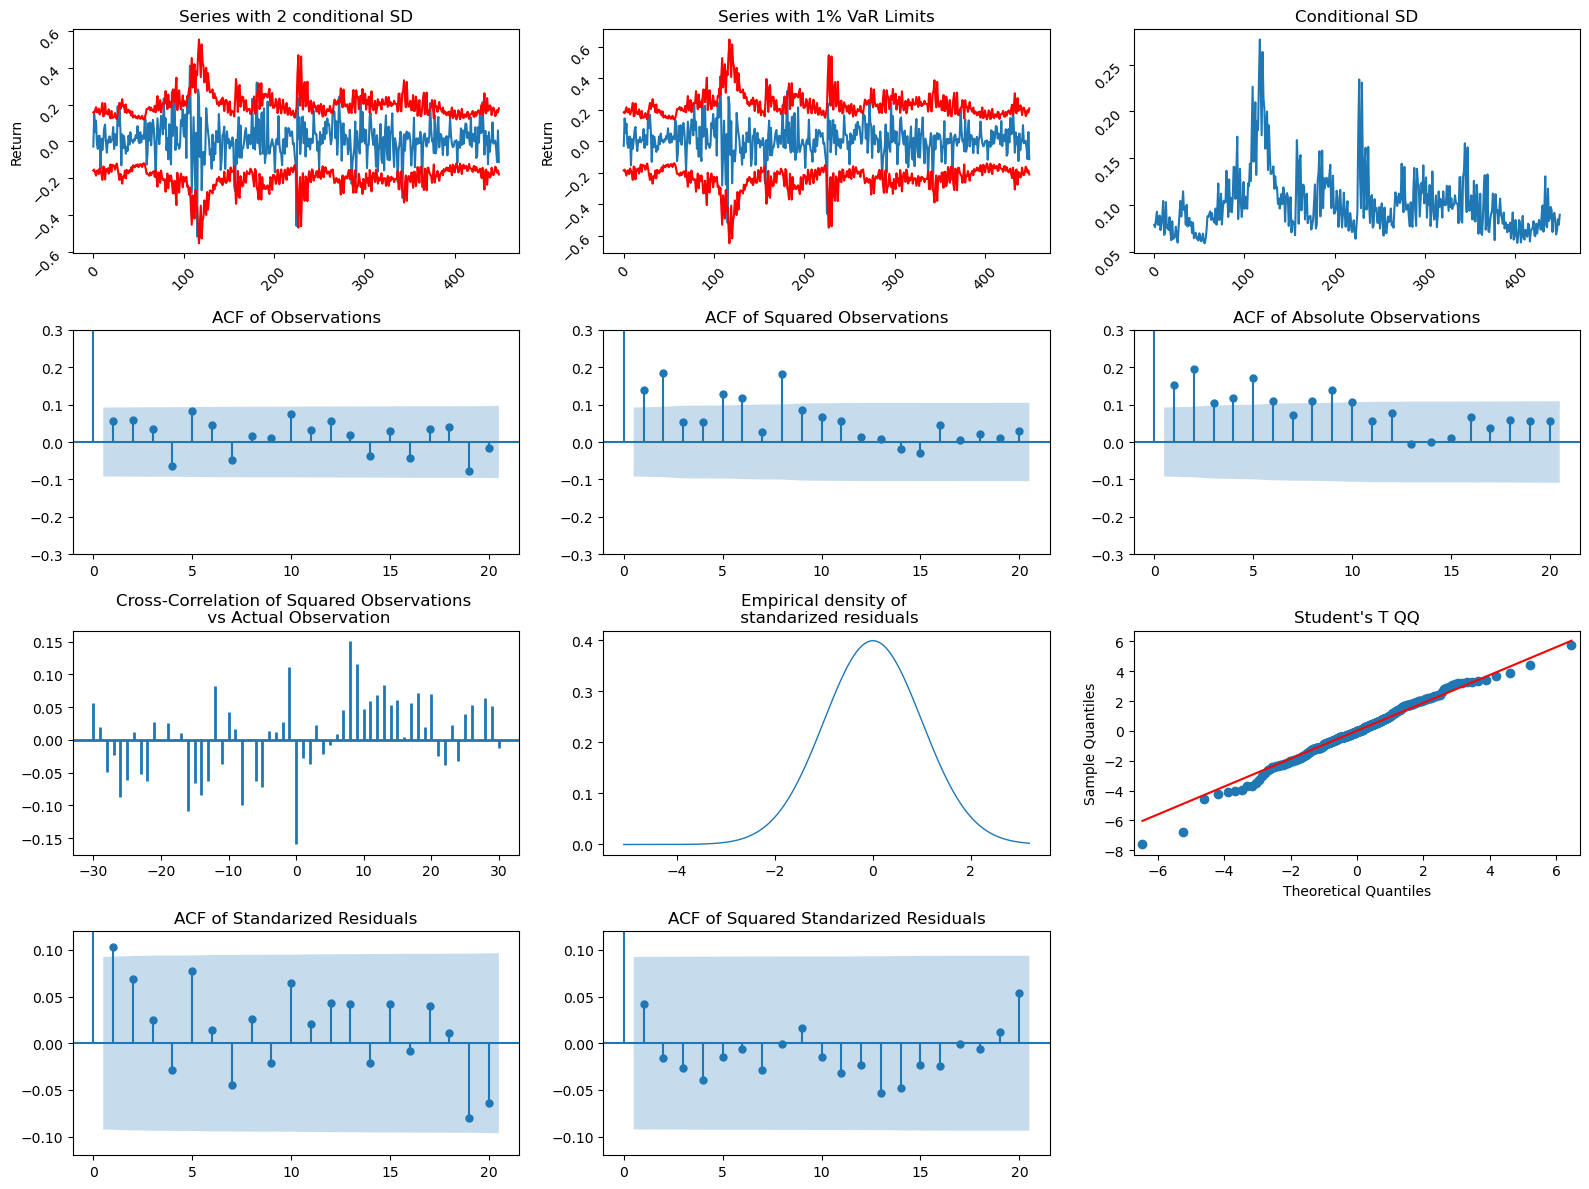

In [11]:
# Model Diagnostic Plots for the GARCH(1,1) Model with Normal White Noise
fig, ax = plt.subplots(4, 3, figsize=(16, 12))

# Figure Row 1 Column 1
ax[0, 0].plot(btc['target'].values)
ax[0, 0].plot(2.0 * garch11_fit.conditional_volatility, c="r")
ax[0, 0].plot(-2.0 * garch11_fit.conditional_volatility, c="r")
ax[0, 0].tick_params(labelrotation=45)
ax[0, 0].set_title("Series with 2 conditional SD")
ax[0, 0].set_ylabel("Return")

# Figure Row 1 Column 2
VaR_1 = stats.t(df=len(btc['target'].values - 1)).ppf(0.99)
ax[0, 1].plot(btc['target'].values)
ax[0, 1].plot(VaR_1 * garch11_fit.conditional_volatility, c="r")
ax[0, 1].plot(-VaR_1 * garch11_fit.conditional_volatility, c="r")
ax[0, 1].tick_params(labelrotation=45)
ax[0, 1].set_title("Series with 1% VaR Limits")
ax[0, 1].set_ylabel("Return")

# Figure Row 1 Column 3
ax[0, 2].plot(garch11_fit.conditional_volatility)
ax[0, 2].set_title("Conditional SD")
ax[0, 2].tick_params(labelrotation=45)

# Figure Row 2 Column 1
plot_acf(garch11_fit.resid, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("ACF of Observations")
ax[1, 0].set_ylim([-0.3, 0.3])

# Figure Row 2 Column 2
plot_acf(garch11_fit.resid**2, lags=20, ax=ax[1, 1])
ax[1, 1].set_title("ACF of Squared Observations")
ax[1, 1].set_ylim([-0.3, 0.3])

# Figure Row 2 Column 3
plot_acf(np.abs(garch11_fit.resid), lags=20, ax=ax[1, 2])
ax[1, 2].set_title("ACF of Absolute Observations")
ax[1, 2].set_ylim([-0.3, 0.3])

# Figure Row 3 Column 1
ax[2, 0].xcorr(
    garch11_fit.resid**2,
    garch11_fit.resid,
    usevlines=True,
    maxlags=30,
    normed=True,
    lw=2,
)
ax[2, 0].set_title("Cross-Correlation of Squared Observations \n vs Actual Observation")

# Figure Row 3 Column 2
standaraized_residuals = garch11_fit.std_resid
min_val = np.min(standaraized_residuals)
max_val = np.max(standaraized_residuals)
empirical_density = np.linspace(min_val, max_val, len(standaraized_residuals))
ax[2, 1].plot(empirical_density, stats.norm.pdf(empirical_density), lw=1)
ax[2, 1].set_title("Empirical density of \n standarized residuals")

# Figure Row 3 Column 3
qqplot(garch11_fit.resid, stats.t, fit=True, line="q", ax=ax[2, 2])
ax[2, 2].set_title("Student's T QQ")

# Figure Row 4 Column 1
plot_acf(garch11_fit.std_resid, lags=20, ax=ax[3, 0])
ax[3, 0].set_title("ACF of Standarized Residuals")
ax[3, 0].set_ylim([-0.12, 0.12])

# Figure Row 4 Column 2
plot_acf((garch11_fit.std_resid) ** 2, lags=20, ax=ax[3, 1])
ax[3, 1].set_title("ACF of Squared Standarized Residuals")
ax[3, 1].set_ylim([-0.12, 0.12])

ax[3, 2].axis("off")
fig.tight_layout()
plt.show()

In [18]:
garch11_fit.forecast().variance

,h.1
449,0.008026
